In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
import os
import cv2
from google.colab.patches import cv2_imshow

In [4]:
path = []
path.append('/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Data/')
path.append('/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Data/tom_cruise_dataset/')  # Images in this folder are named 1_(.)
path.append('/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Data/katrina_kaif_dataset/')  # Images in this folder are named 2_(.)
path.append('/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Data/Elizabeth_Olsen/')  # Images in this folder are named 3_(.)
path.append('/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Data/Scarlett_Johansson/')  # Images in this folder are named 4_(.)

In [5]:
# Defining a special function to resize images, capable of handling corner cases

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [6]:
import matplotlib.pyplot as plt
import shutil

In [7]:
from PIL import Image
import os, sys

path = '/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Data'
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((224,224), Image.ANTIALIAS)
            imResize.save(f + ' resized.jpg', 'JPEG', quality=90)

resize()

In [8]:
!pip install git+https://github.com/rcmalli/keras-vggface

  Cloning https://github.com/rcmalli/keras-vggface to /tmp/pip-req-build-ga0nuqpr
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface /tmp/pip-req-build-ga0nuqpr
  Resolved https://github.com/rcmalli/keras-vggface to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8296 sha256=ea2b60851530707c1004ad21476b87fd990ecb2701a4163424a216f50cfbbcd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6xkx2e5s/wheels/b5/8c/a4/a8342283d8715b44e09eb4d985b7fc54f04c937f3b0a104ea9
Successfully built keras-vggface


In [9]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 857.3 kB/s eta 0:00:00


In [10]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.4 MB/s eta 0:00:00


In [11]:
import tensorflow as tf
import keras
import keras_vggface
from keras_vggface.vggface import VGGFace
import mtcnn
import numpy as np
import matplotlib as mpl
from keras.utils.data_utils import get_file
import keras_vggface.utils
import PIL
import os
import os.path

In [12]:
vggface = VGGFace(model = 'vgg16')
vggface_resnet = VGGFace(model = 'resnet50')
vggface_senet = VGGFace(model = 'senet50')

175688524/175688524 [==============================] - 2s 0us/step


In [13]:
print(vggface.summary())
print("Inputs: ", vggface.inputs)
print("Outputs: ", vggface.outputs)

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [14]:
train_dataset = keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Data', shuffle = True, batch_size = 8, image_size = (224, 224))

Found 439 files belonging to 4 classes.


In [15]:
os.listdir('/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Data')

['Elizabeth_Olsen',
 'Scarlett_Johansson',
 'katrina_kaif_dataset',
 'tom_cruise_dataset',
 '.DS_Store']

In [16]:
data_augmentation = keras.Sequential([keras.layers.RandomFlip("horizontal"),
                                      keras.layers.RandomRotation(0.2),])

In [17]:
vggface_resnet_base = VGGFace(model = 'resnet50', include_top = False, input_shape = (224, 224, 3))

94694792/94694792 [==============================] - 1s 0us/step


In [18]:
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

nb_class = 4

# Freezing the base model
vggface_resnet_base.trainable = False
last_layer = vggface_resnet_base.get_layer("avg_pool").output

# Building up the new model
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)

x = vggface_resnet_base(x)

x = Flatten(name = 'flatten')(x)

out = Dense(nb_class, name = 'classifier')(x)

custom_vgg_model = keras.Model(inputs, out)

In [19]:
base_learning_rate = 0.0001

custom_vgg_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
                         loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                         metrics = ['accuracy'])

In [20]:
history = custom_vgg_model.fit(train_dataset, epochs = 20)

Epoch 1/20
55/55 [==============================] - 93s 1s/step - loss: 1.4860 - accuracy: 0.4920
Epoch 2/20
55/55 [==============================] - 78s 1s/step - loss: 0.5733 - accuracy: 0.7722
Epoch 3/20
55/55 [==============================] - 78s 1s/step - loss: 0.4360 - accuracy: 0.8200
Epoch 4/20
55/55 [==============================] - 93s 2s/step - loss: 0.3781 - accuracy: 0.8497
Epoch 5/20
55/55 [==============================] - 79s 1s/step - loss: 0.2951 - accuracy: 0.8815
Epoch 6/20
55/55 [==============================] - 78s 1s/step - loss: 0.3260 - accuracy: 0.8770
Epoch 7/20
55/55 [==============================] - 79s 1s/step - loss: 0.2665 - accuracy: 0.8884
Epoch 8/20
55/55 [==============================] - 78s 1s/step - loss: 0.3054 - accuracy: 0.8656
Epoch 9/20
55/55 [==============================] - 79s 1s/step - loss: 0.2420 - accuracy: 0.9089
Epoch 10/20
55/55 [==============================] - 82s 1s/step - loss: 0.2472 - accuracy: 0.9021
Epoch 11/20
55/55 [

In [21]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blinker                          1.4
bl

In [23]:
x_test = []

In [ ]:
# DO NOT RUN THIS CELL.

from PIL import Image
import os, sys

path = '/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Samples/samples/'
dirs = os.listdir(path)

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((224,224), Image.ANTIALIAS)
            imResize.save(f + ' resized.jpg', 'JPEG', quality=90)

resize()

<ipython-input-94-07d6189650db>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imResize = im.resize((224,224), Image.ANTIALIAS)


['kk_test1 resized.jpg', 'kk_test5 resized.jpg', 'kk_test4 resized.jpg', 'kk_test3 resized.jpg', 'kk_test2 resized.jpg', 'eo_test2 resized.jpg', 'eo_test5 resized.jpg', 'eo_test4 resized.jpg', 'eo_test3 resized.jpg', 'eo_test1 resized.jpg', 'tc_test3 resized.jpg', 'tc_test5 resized.jpg', 'tc_test4 resized.jpg', 'tc_test2 resized.jpg', 'sj_test4 resized.jpg', 'sj_test3 resized.jpg', 'tc_test1 resized.jpg', 'sj_test5 resized.jpg', 'sj_test2 resized.jpg', 'sj_test1 resized.jpg']


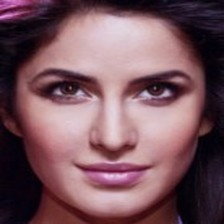

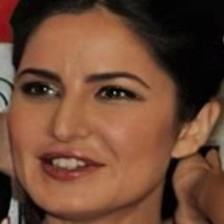

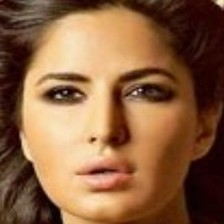

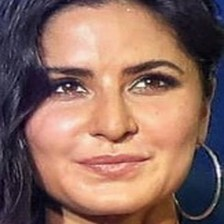

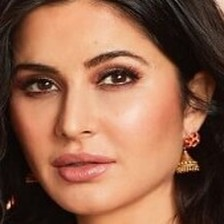

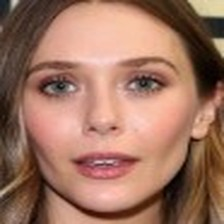

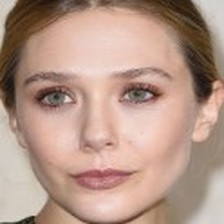

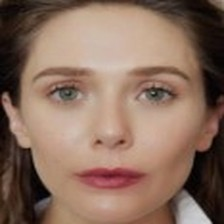

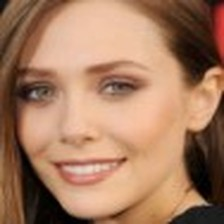

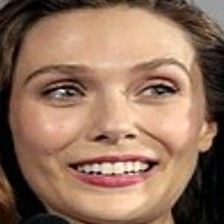

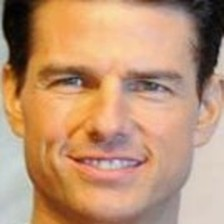

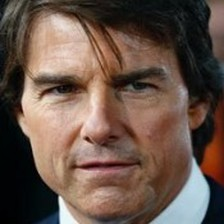

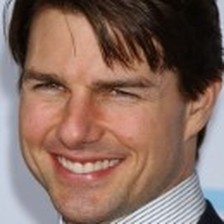

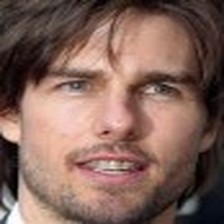

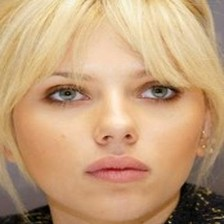

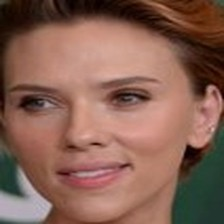

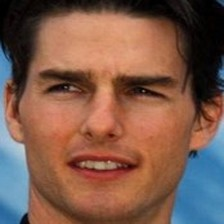

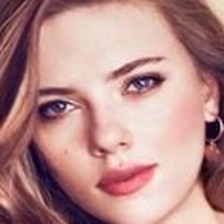

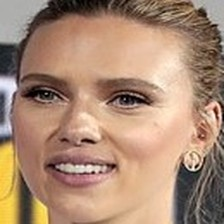

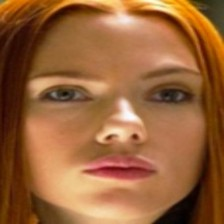

In [33]:
dir_list = os.listdir('/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Samples/samples/')
print(dir_list)

for i in dir_list:
    image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/SOC_Final_Project/Samples/samples/' + i)
    # image = image_resize(image, 224, 224)
    # image_data = tf.image.encode_jpeg(image)
    # fnames = ['{}_({}).jpg'.format(i, k+1) for k in range(80)]
    # if(len(x_test) < 21):
    cv2_imshow(image)
    x_test.append(image)

In [36]:
len(x_test)

20

In [35]:
x_test = x_test[0:20]  # This will ensure that running the code again and again does not keep appending to the test set.

In [37]:
prob_model = keras.Sequential([custom_vgg_model, tf.keras.layers.Softmax()])

In [38]:
os.getcwd()

'/content'

In [39]:
x_test

[array([[[131,  63, 150],
         [137,  69, 156],
         [150,  82, 167],
         ...,
         [ 24,  11,  19],
         [ 25,  12,  20],
         [ 26,  13,  21]],
 
        [[148,  80, 169],
         [143,  75, 162],
         [143,  74, 161],
         ...,
         [ 23,  10,  18],
         [ 24,  11,  19],
         [ 26,  13,  21]],
 
        [[125,  58, 149],
         [121,  55, 144],
         [123,  55, 144],
         ...,
         [ 20,   7,  15],
         [ 20,   7,  15],
         [ 21,   8,  16]],
 
        ...,
 
        [[ 31,  17,  29],
         [ 30,  16,  28],
         [ 29,  15,  26],
         ...,
         [ 14,   7,  20],
         [ 11,   4,  17],
         [  9,   2,  15]],
 
        [[ 32,  16,  27],
         [ 30,  14,  25],
         [ 28,  12,  23],
         ...,
         [ 12,   5,  18],
         [ 11,   4,  17],
         [ 12,   5,  18]],
 
        [[ 33,  17,  28],
         [ 31,  15,  26],
         [ 28,  12,  23],
         ...,
         [ 11,   4,  17],
  

In [51]:
predictions = prob_model.predict(np.array(x_test))
predictions

1/1 [==============================] - 3s 3s/step


array([[3.7630421e-06, 1.1755416e-06, 9.9999446e-01, 5.6334824e-07],
       [9.8665600e-07, 1.4215971e-05, 9.9997300e-01, 1.1624623e-05],
       [8.1034965e-09, 1.3526517e-07, 9.9999982e-01, 2.6685683e-08],
       [1.6981125e-05, 1.8505694e-06, 9.9995595e-01, 2.5158110e-05],
       [2.3306004e-05, 8.7736531e-05, 9.9986649e-01, 2.2545137e-05],
       [9.9992472e-01, 5.9926369e-05, 3.7837946e-08, 1.5273217e-05],
       [9.9894172e-01, 1.1347896e-04, 1.5403552e-06, 9.4330090e-04],
       [9.9998707e-01, 1.0554943e-05, 8.2151978e-08, 2.1133192e-06],
       [9.9964511e-01, 3.1584618e-04, 3.6475008e-06, 3.5370984e-05],
       [9.9746901e-01, 2.1160850e-03, 3.5661728e-07, 4.1445985e-04],
       [1.2445110e-09, 9.9610239e-05, 2.7559364e-07, 9.9990004e-01],
       [6.6247061e-08, 1.5133013e-07, 1.6508244e-06, 9.9999803e-01],
       [2.2482268e-06, 1.7413190e-06, 6.9441389e-06, 9.9998897e-01],
       [2.0914315e-06, 2.3747598e-06, 3.0086027e-05, 9.9996537e-01],
       [9.5949308e-06, 9.9999028e-

In [52]:
predictions.shape

(20, 4)

In [55]:
from tensorflow.python.ops.gen_math_ops import arg_max
output_labels = []

for i in range(predictions.shape[0]):
    output_labels.append(predictions[i].argmax())

output_labels

[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1]